In [1]:
import pandas as pd

In [2]:
df_reports = pd.read_pickle('data/preprocessed_reports.pkl')
df_report_pairs = pd.read_pickle('data/preprocessed_report_pairs.pkl')

# TF-IDF

In [3]:
df_reports.shape, df_reports.columns

((892, 19),
 Index(['report_id', 'creation_time', 'status', 'component', 'dupe_of',
        'summary', 'comments', 'text1', 'text2', 'text3', 'text4', 'tokens1L',
        'tokens2L', 'tokens3L', 'tokens4L', 'tokens1S', 'tokens2S', 'tokens3S',
        'tokens4S'],
       dtype='object'))

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
tfidf1L = TfidfVectorizer()
x1L = tfidf1L.fit_transform(df_reports['tokens1L'].apply(lambda x: ' '.join(x)))
tfidf2L = TfidfVectorizer()
x2L = tfidf2L.fit_transform(df_reports['tokens2L'].apply(lambda x: ' '.join(x)))
tfidf3L = TfidfVectorizer()
x3L = tfidf3L.fit_transform(df_reports['tokens3L'].apply(lambda x: ' '.join(x)))
tfidf4L = TfidfVectorizer()
x4L = tfidf4L.fit_transform(df_reports['tokens4L'].apply(lambda x: ' '.join(x)))

tfidf1S = TfidfVectorizer()
x1S = tfidf1S.fit_transform(df_reports['tokens1S'].apply(lambda x: ' '.join(x)))
tfidf2S = TfidfVectorizer()
x2S = tfidf2S.fit_transform(df_reports['tokens2S'].apply(lambda x: ' '.join(x)))
tfidf3S = TfidfVectorizer()
x3S = tfidf3S.fit_transform(df_reports['tokens3S'].apply(lambda x: ' '.join(x)))
tfidf4S = TfidfVectorizer()
x4S = tfidf4S.fit_transform(df_reports['tokens4S'].apply(lambda x: ' '.join(x)))

In [6]:
x1S.toarray().shape, len(tfidf1L.get_feature_names_out())

((892, 1695), 1986)

# KMeans

In [7]:
from sklearn.cluster import KMeans
from kneed import knee_locator

In [8]:
RANGE_CLUSTERS = range(1,10)
from sklearn.metrics import accuracy_score

def get_k_means_results(x):
    # Entrenar modelos con distintos numeros de clusteres
    kmeans = [KMeans(n_clusters=i).fit(x) for i in RANGE_CLUSTERS]
    # Obtener inercia para cada modelo
    inertias = [kmeans[i].inertia_ for i in range(len(kmeans))]
    # Obtener cluster resultante de cada reporte de cada modelo
    # Obtener también la precisión (parejas cuyo clusterM y clusterD coincide)
    dfps = []
    dfrs = []
    accuracies = []
    for k in kmeans:
        dfr = df_reports.copy()
        dfr['cluster'] = k.labels_
        dfp = df_report_pairs.copy()
        dfp['clusterM'] = [None for _ in range(len(dfp))]
        dfp['clusterD'] = [None for _ in range(len(dfp))]
        for i, row in dfp.iterrows():
            row['clusterM'] = str(int(dfr[dfr['report_id'] == row['id_M']]['cluster']))
            row['clusterD'] = str(int(dfr[dfr['report_id'] == row['id_D']]['cluster']))
        dfps.append(dfp)
        dfrs.append(dfr)
        accuracies.append(accuracy_score(dfp['clusterM'], dfp['clusterD']))
    return {
        'models':kmeans,
        'inertias':inertias,
        'dfps': dfps,
        'dfrs': dfrs,
        'accuracies': accuracies
    }

In [9]:
kmeans1L = get_k_means_results(x1L)
kmeans2L = get_k_means_results(x2L)
kmeans3L = get_k_means_results(x3L)
kmeans4L = get_k_means_results(x4L)
kmeans1S = get_k_means_results(x1S)
kmeans2S = get_k_means_results(x2S)
kmeans3S = get_k_means_results(x3S)
kmeans4S = get_k_means_results(x4S)

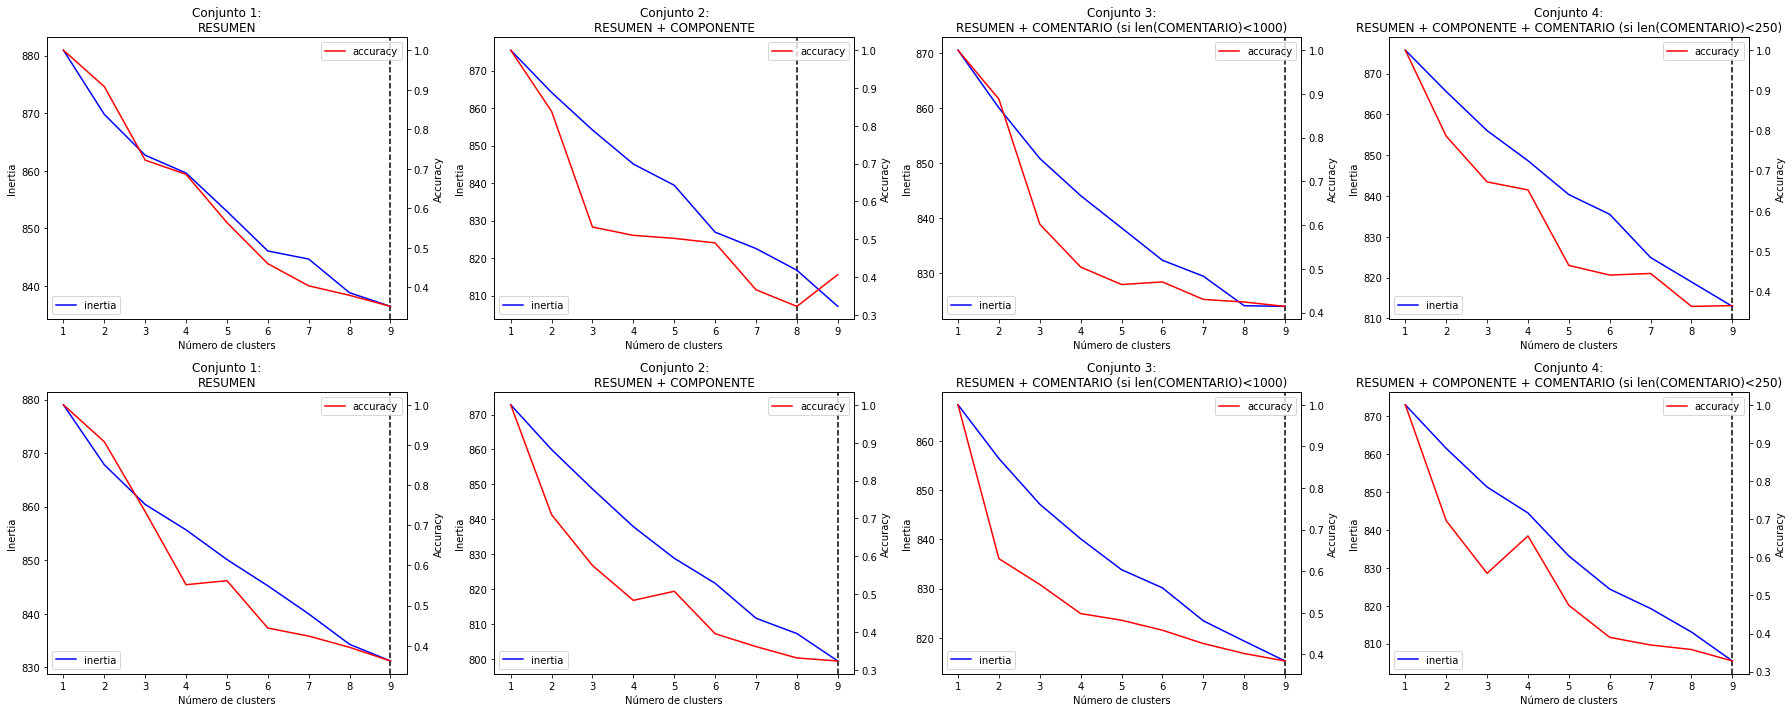

In [10]:
import matplotlib.pyplot as plt
from kneed import KneeLocator

fig, axs = plt.subplots(2, 4, figsize=(25,10))

axs[0,0].set_title('Conjunto 1:\nRESUMEN')
axs[0,0].set_xlabel('Número de clusters')
axs[0,0].axvline(x=KneeLocator(RANGE_CLUSTERS, kmeans1L['inertias'], curve='concave', direction='decreasing').knee, color='black', linestyle='--')
axs[0,0].plot(RANGE_CLUSTERS, kmeans1L['inertias'], color='blue', label='inertia')
axs[0,0].set_ylabel('Inertia')
axs1L = axs[0,0].twinx()
axs1L.plot(RANGE_CLUSTERS, kmeans1L['accuracies'], color='red', label='accuracy')
axs1L.set_ylabel('Accuracy')
axs[0,0].legend(loc='lower left')
axs1L.legend(loc='upper right')

axs[0,1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[0,1].set_xlabel('Número de clusters')
axs[0,1].axvline(x=KneeLocator(RANGE_CLUSTERS, kmeans2L['inertias'], curve='concave', direction='decreasing').knee, color='black', linestyle='--')
axs[0,1].plot(RANGE_CLUSTERS, kmeans2L['inertias'], color='blue', label='inertia')
axs[0,1].set_ylabel('Inertia')
axs2L = axs[0,1].twinx()
axs2L.plot(RANGE_CLUSTERS, kmeans2L['accuracies'], color='red', label='accuracy')
axs2L.set_ylabel('Accuracy')
axs[0,1].legend(loc='lower left')
axs2L.legend(loc='upper right')

axs[0,2].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[0,2].set_xlabel('Número de clusters')
axs[0,2].axvline(x=KneeLocator(RANGE_CLUSTERS, kmeans3L['inertias'], curve='concave', direction='decreasing').knee, color='black', linestyle='--')
axs[0,2].plot(RANGE_CLUSTERS, kmeans3L['inertias'], color='blue', label='inertia')
axs[0,2].set_ylabel('Inertia')
axs3L = axs[0,2].twinx()
axs3L.plot(RANGE_CLUSTERS, kmeans3L['accuracies'], color='red', label='accuracy')
axs3L.set_ylabel('Accuracy')
axs[0,2].legend(loc='lower left')
axs3L.legend(loc='upper right')

axs[0,3].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[0,3].set_xlabel('Número de clusters')
axs[0,3].axvline(x=KneeLocator(RANGE_CLUSTERS, kmeans4L['inertias'], curve='concave', direction='decreasing').knee, color='black', linestyle='--')
axs[0,3].plot(RANGE_CLUSTERS, kmeans4L['inertias'], color='blue', label='inertia')
axs[0,3].set_ylabel('Inertia')
axs4L = axs[0,3].twinx()
axs4L.plot(RANGE_CLUSTERS, kmeans4L['accuracies'], color='red', label='accuracy')
axs4L.set_ylabel('Accuracy')
axs[0,3].legend(loc='lower left')
axs4L.legend(loc='upper right')

axs[1,0].set_title('Conjunto 1:\nRESUMEN')
axs[1,0].set_xlabel('Número de clusters')
axs[1,0].axvline(x=KneeLocator(RANGE_CLUSTERS, kmeans1S['inertias'], curve='concave', direction='decreasing').knee, color='black', linestyle='--')
axs[1,0].plot(RANGE_CLUSTERS, kmeans1S['inertias'], color='blue', label='inertia')
axs[1,0].set_ylabel('Inertia')
axs1S = axs[1,0].twinx()
axs1S.plot(RANGE_CLUSTERS, kmeans1S['accuracies'], color='red', label='accuracy')
axs1S.set_ylabel('Accuracy')
axs[1,0].legend(loc='lower left')
axs1S.legend(loc='upper right')

axs[1,1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[1,1].set_xlabel('Número de clusters')
axs[1,1].axvline(x=KneeLocator(RANGE_CLUSTERS, kmeans2S['inertias'], curve='concave', direction='decreasing').knee, color='black', linestyle='--')
axs[1,1].plot(RANGE_CLUSTERS, kmeans2S['inertias'], color='blue', label='inertia')
axs[1,1].set_ylabel('Inertia')
axs2S = axs[1,1].twinx()
axs2S.plot(RANGE_CLUSTERS, kmeans2S['accuracies'], color='red', label='accuracy')
axs2S.set_ylabel('Accuracy')
axs[1,1].legend(loc='lower left')
axs2S.legend(loc='upper right')

axs[1,2].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[1,2].set_xlabel('Número de clusters')
axs[1,2].axvline(x=KneeLocator(RANGE_CLUSTERS, kmeans3S['inertias'], curve='concave', direction='decreasing').knee, color='black', linestyle='--')
axs[1,2].plot(RANGE_CLUSTERS, kmeans3S['inertias'], color='blue', label='inertia')
axs[1,2].set_ylabel('Inertia')
axs3S = axs[1,2].twinx()
axs3S.plot(RANGE_CLUSTERS, kmeans3S['accuracies'], color='red', label='accuracy')
axs3S.set_ylabel('Accuracy')
axs[1,2].legend(loc='lower left')
axs3S.legend(loc='upper right')

axs[1,3].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[1,3].set_xlabel('Número de clusters')
axs[1,3].axvline(x=KneeLocator(RANGE_CLUSTERS, kmeans4S['inertias'], curve='concave', direction='decreasing').knee, color='black', linestyle='--')
axs[1,3].plot(RANGE_CLUSTERS, kmeans4S['inertias'], color='blue', label='inertia')
axs[1,3].set_ylabel('Inertia')
axs4S = axs[1,3].twinx()
axs4S.plot(RANGE_CLUSTERS, kmeans4S['accuracies'], color='red', label='accuracy')
axs4S.set_ylabel('Accuracy')
axs[1,3].legend(loc='lower left')
axs4S.legend(loc='upper right')

fig.tight_layout()
plt.show()

## Mejor modelo para cada conjunto

In [11]:
def get_best_model(results):
    accuracies = results['accuracies']
    best_index = [i for i,acc in enumerate(accuracies) if acc > 0.75]
    best_index = best_index[-1] if len(best_index) > 1 else 1
    print(f'Número de clústers: ', best_index+1)
    return results['models'][best_index], results['dfps'][best_index], results['dfrs'][best_index]

In [12]:
kmeans1L_best_model, df_report_pairs1L, df_reports1L = get_best_model(kmeans1L)
kmeans2L_best_model, df_report_pairs2L, df_reports2L = get_best_model(kmeans2L)
kmeans3L_best_model, df_report_pairs3L, df_reports3L = get_best_model(kmeans3L)
kmeans4L_best_model, df_report_pairs4L, df_reports4L = get_best_model(kmeans4L)
kmeans1S_best_model, df_report_pairs1S, df_reports1S = get_best_model(kmeans1S)
kmeans2S_best_model, df_report_pairs2S, df_reports2S = get_best_model(kmeans2S)
kmeans3S_best_model, df_report_pairs3S, df_reports3S = get_best_model(kmeans3S)
kmeans4S_best_model, df_report_pairs4S, df_reports4S = get_best_model(kmeans4S)

Número de clústers:  2
Número de clústers:  2
Número de clústers:  2
Número de clústers:  2
Número de clústers:  2
Número de clústers:  2
Número de clústers:  2
Número de clústers:  2


## Resultados iniciales de cada modelo

### Palabras clave de cada cluster

In [13]:
import numpy as np

def print_clusters_keywords(n_keywords, X, clusters, vec):
    df = pd.DataFrame(X.todense()).groupby(clusters).mean()
    terms = vec.get_feature_names_out()
    for i,r in df.iterrows():
        print(f'Cluster {i} -> ', end='')
        print(', '.join([terms[t] for t in np.argsort(r)[-n_keywords:]]), end='\n')

In [14]:
# Imprimir keywords de los clusters de los diferentes conjuntos
print('---------------------------------------')
print('TÉRMINOS CLAVE EN CONJUNTOS CON LEMMATIZER')
print('---------------------------------------')
print('CONJUNTO 1 (RESUMEN):')
print_clusters_keywords(10, x1L, kmeans1L_best_model.labels_, tfidf1L)
print('-'*25)
print('CONJUNTO 2 (RESUMEN + COMPONENTE):')
print_clusters_keywords(10, x2L, kmeans2L_best_model.labels_, tfidf2L)
print('-'*25)
print('CONJUNTO 3 (RESUMEN + COMENTARIO (si len(COMENTARIO)<1000)):')
print_clusters_keywords(10, x3L, kmeans3L_best_model.labels_, tfidf3L)
print('-'*25)
print('CONJUNTO 4 (RESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)):')
print_clusters_keywords(10, x4L, kmeans4L_best_model.labels_, tfidf4L)
print('---------------------------------------')
print('TÉRMINOS CLAVE EN CONJUNTOS CON STEMMER')
print('---------------------------------------')
print('CONJUNTO 1 (RESUMEN):')
print_clusters_keywords(10, x1S, kmeans1S_best_model.labels_, tfidf1S)
print('-'*25)
print('CONJUNTO 2 (RESUMEN + COMPONENTE):')
print_clusters_keywords(10, x2S, kmeans2S_best_model.labels_, tfidf2S)
print('-'*25)
print('CONJUNTO 3 (RESUMEN + COMENTARIO (si len(COMENTARIO)<1000)):')
print_clusters_keywords(10, x3S, kmeans3S_best_model.labels_, tfidf3S)
print('-'*25)
print('CONJUNTO 4 (RESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)):')
print_clusters_keywords(10, x4S, kmeans4S_best_model.labels_, tfidf4S)


---------------------------------------
TÉRMINOS CLAVE EN CONJUNTOS CON LEMMATIZER
---------------------------------------
CONJUNTO 1 (RESUMEN):
Cluster 0 -> open, bar, bookmark, page, add, new, firefox, window, search, tab
Cluster 1 -> pdf, base, version, application, content, component, intermittent, test, browser, js
-------------------------
CONJUNTO 2 (RESUMEN + COMPONENTE):
Cluster 0 -> bookmark, untriaged, window, general, search, sync, new, page, browser, tab
Cluster 1 -> result, port, intervention, tip, location, urlbar, search, url, address, bar
-------------------------
CONJUNTO 3 (RESUMEN + COMENTARIO (si len(COMENTARIO)<1000)):
Cluster 0 -> https, crashed, base, application, content, component, intermittent, browser, js, test
Cluster 1 -> bug, user, page, new, open, search, result, window, firefox, tab
-------------------------
CONJUNTO 4 (RESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)):
Cluster 0 -> js, firefox, untriaged, general, window, sync, new, page, bro

### PCA y graficado

In [15]:
from sklearn.decomposition import PCA

def add_pca_to_df(df, x):
    pca = PCA(n_components=2)
    pca_vecs = pca.fit_transform(x.toarray())
    df['pca_x'] = pca_vecs[:,0]
    df['pca_y'] = pca_vecs[:,1]

In [16]:
add_pca_to_df(df_reports1L, x1L)
add_pca_to_df(df_reports2L, x2L)
add_pca_to_df(df_reports3L, x3L)
add_pca_to_df(df_reports4L, x4L)
add_pca_to_df(df_reports1S, x1S)
add_pca_to_df(df_reports2S, x2S)
add_pca_to_df(df_reports3S, x3S)
add_pca_to_df(df_reports4S, x4S)

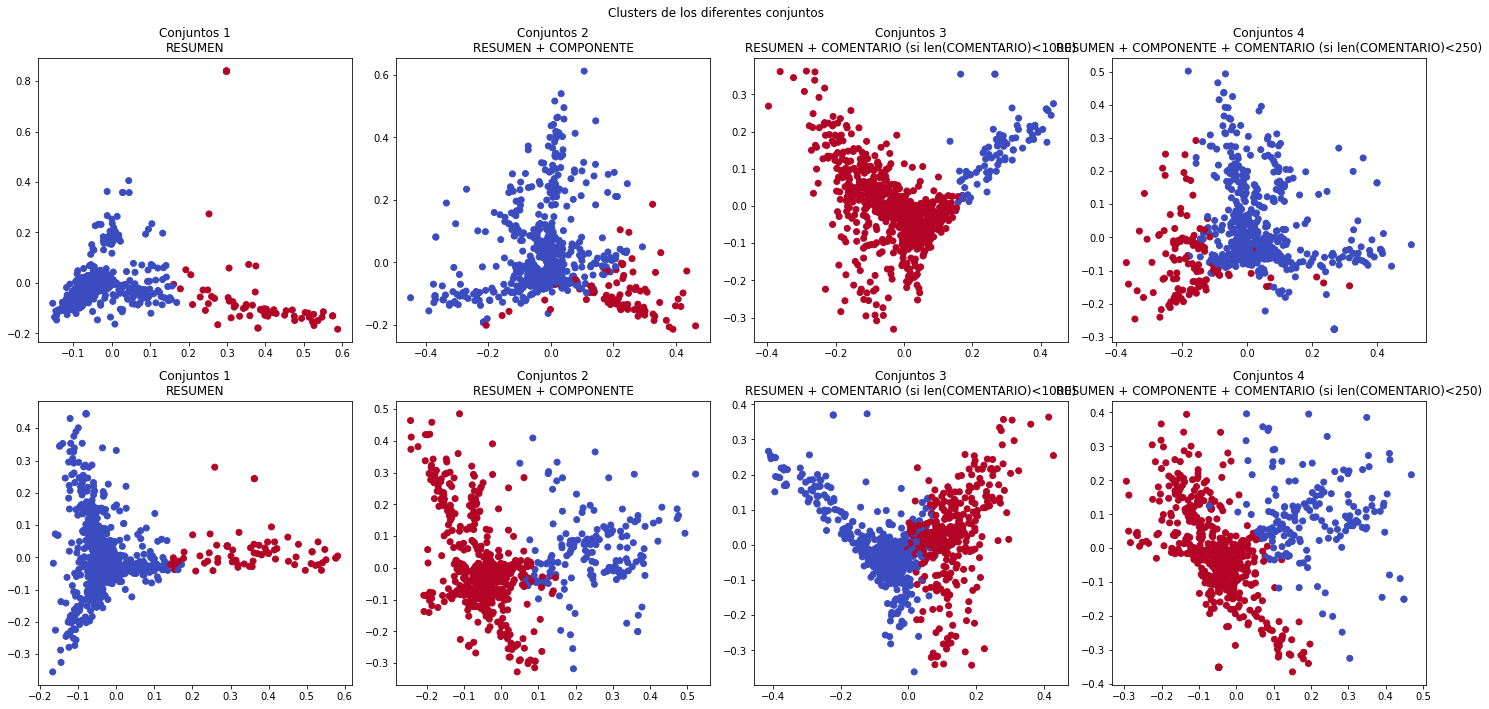

In [17]:
fig, axs = plt.subplots(2,4, figsize=(20,10))

fig.suptitle('Clusters de los diferentes conjuntos')

axs[0,0].scatter(df_reports1L['pca_x'], df_reports1L['pca_y'], c=df_reports1L['cluster'], cmap='coolwarm')
axs[0,0].set_title('Conjuntos 1\nRESUMEN')

axs[0,1].scatter(df_reports2L['pca_x'], df_reports2L['pca_y'], c=df_reports2L['cluster'], cmap='coolwarm')
axs[0,1].set_title('Conjuntos 2\nRESUMEN + COMPONENTE')

axs[0,2].scatter(df_reports3L['pca_x'], df_reports3L['pca_y'], c=df_reports3L['cluster'], cmap='coolwarm')
axs[0,2].set_title('Conjuntos 3\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')

axs[0,3].scatter(df_reports4L['pca_x'], df_reports4L['pca_y'], c=df_reports4L['cluster'], cmap='coolwarm')
axs[0,3].set_title('Conjuntos 4\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')

axs[1,0].scatter(df_reports1S['pca_x'], df_reports1S['pca_y'], c=df_reports1S['cluster'], cmap='coolwarm')
axs[1,0].set_title('Conjuntos 1\nRESUMEN')

axs[1,1].scatter(df_reports2S['pca_x'], df_reports2S['pca_y'], c=df_reports2S['cluster'], cmap='coolwarm')
axs[1,1].set_title('Conjuntos 2\nRESUMEN + COMPONENTE')

axs[1,2].scatter(df_reports3S['pca_x'], df_reports3S['pca_y'], c=df_reports3S['cluster'], cmap='coolwarm')
axs[1,2].set_title('Conjuntos 3\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')

axs[1,3].scatter(df_reports4S['pca_x'], df_reports4S['pca_y'], c=df_reports4S['cluster'], cmap='coolwarm')
axs[1,3].set_title('Conjuntos 4\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')

fig.tight_layout()
plt.show()

## Kmeans recursivo para parejas MAESTRO-DUPLICADO

In [18]:
def recursive_cluster(report, tfidf, kmeans, df_clustered_reports, max_recursivity_lvl=None, max_reports_cluster=None, tokenize_type='tokens1S'): # One sentence
    """
    Recursive function to cluster a report
    Args:
        report:pd.DataFrame with the report to be clustered. Must have at least report_id and text columns
        tfidf:tfidf fit with all the data. Retrieved from pickle
        kmeans:kmeans model fit with all the data. Retrieved from pickle
        df_clustered_reports:pd.DataFrame with all the data and the initial cluster (from kmeans training)
        max_recursivity_lvl:int with the maximum recursivity level. DEFAULT MODE.
        max_reports_cluster:int with the maximum number of reports in the final cluster. max_recursivity_lvl will be used if both are set
        tokenize_type:str with the type of tokenization to be used. In the future this wont be a parameter.
    """
    # Criterios
    REC_LVL = 'RECURSIVITY_LEVEL'
    REP_CLU = 'REPORTS_PER_CLUSTER'

    if max_recursivity_lvl is None and max_reports_cluster is None:
        print('No recursivity level or max_reports_cluster set. Aborting')
        return
    elif max_reports_cluster and max_reports_cluster >= 2:
        criteria = REP_CLU
    elif max_recursivity_lvl > 1:
        criteria = REC_LVL


    # Obtener el cluster inicial del reporte respecto a todos los reportes
    # TODO: Añadir preprocessing
    tokens = report[tokenize_type].iloc[0] # TODO: en el futuro solo habrá 'tokens' o se añadirá el preprocesamiento
    # Obtener features del nuevo reporte
    features = tfidf.transform([' '.join(tokens)])
    # Obtener el cluster del nuevo reporte basandose en el modelo global
    cluster = kmeans.predict(features)[0]
    # Añadir cluster al df que representa el reporte
    report['cluster'] = cluster

    # Obtener los reportes con el mismo cluster
    df_same_cluster = df_clustered_reports[df_clustered_reports['cluster'] == cluster]
    df_same_cluster = df_same_cluster.reset_index(drop=True)
    # Añadir el nuevo reporte clusterizado al conjunto de mismo cluster
    df_same_cluster = pd.concat([df_same_cluster, report])

    limit = 1 if criteria == REC_LVL else max_reports_cluster
    current = max_recursivity_lvl if criteria == REC_LVL else len(df_same_cluster)

    while current > limit:
        # TODO: tokenize -> create column
        # Obtener las features del nuevo conjunto
        x = tfidf.transform(df_same_cluster[tokenize_type].apply(' '.join))
        # Entrenar un modelo menor con el nuevo conjunto
        rec_kmeans = KMeans(n_clusters=kmeans.n_clusters).fit(x)
        # Añadir la predicción del modelo al conjunto
        df_same_cluster['cluster'] = rec_kmeans.predict(x)
        # Obtener el cluster del nuevo reporte basandose en el modelo más pequeño
        cluster = rec_kmeans.predict(features)[0]
        
        # Obtener los reportes con el mismo cluster dentro del subconjunto previo
        df_same_cluster = df_same_cluster[df_same_cluster['cluster'] == cluster]
        df_same_cluster = df_same_cluster.reset_index(drop=True)
        # No hace falta añadir el nuevo reporte pues ya estaba incluido

        current = current-1 if criteria == REC_LVL else len(df_same_cluster)

    return cluster, df_same_cluster

In [19]:
dfp = df_report_pairs1S.copy()
dfr = df_reports1S.copy()

# Obtener 8 parejas de ejemplo
df_pair_sample = dfp[dfp['type'] == 'duplicate'].sample(8)
# Obtener los IDs de los duplicados de esas parejas
ids = df_pair_sample['id_D'].values

# Obtener un dataframe para cada reporte
sample_1L = dfr[dfr['report_id'] == ids[0]]
sample_2L = dfr[dfr['report_id'] == ids[1]]
sample_3L = dfr[dfr['report_id'] == ids[2]]
sample_4L = dfr[dfr['report_id'] == ids[3]]
sample_1S = dfr[dfr['report_id'] == ids[4]]
sample_2S = dfr[dfr['report_id'] == ids[5]]
sample_3S = dfr[dfr['report_id'] == ids[6]]
sample_4S = dfr[dfr['report_id'] == ids[7]]

# # Borrar los duplicados de la lista de reportes
dfr = dfr.drop(dfr[dfr['report_id'].isin(ids)].index)
df_pair_sample.reset_index(drop=True, inplace=True)

In [20]:
cluster1L, cluster_data1L = recursive_cluster(sample_1L, tfidf1L, kmeans1L_best_model, dfr, max_reports_cluster=100, tokenize_type='tokens1L')
cluster2L, cluster_data2L = recursive_cluster(sample_2L, tfidf2L, kmeans2L_best_model, dfr, max_reports_cluster=100, tokenize_type='tokens2L')
cluster3L, cluster_data3L = recursive_cluster(sample_3L, tfidf3L, kmeans3L_best_model, dfr, max_reports_cluster=100, tokenize_type='tokens3L')
cluster4L, cluster_data4L = recursive_cluster(sample_4L, tfidf4L, kmeans4L_best_model, dfr, max_reports_cluster=100, tokenize_type='tokens4L')
cluster1S, cluster_data1S = recursive_cluster(sample_1S, tfidf1S, kmeans1S_best_model, dfr, max_reports_cluster=100, tokenize_type='tokens1S')
cluster2S, cluster_data2S = recursive_cluster(sample_2S, tfidf2S, kmeans2S_best_model, dfr, max_reports_cluster=100, tokenize_type='tokens2S')
cluster3S, cluster_data3S = recursive_cluster(sample_3S, tfidf3S, kmeans3S_best_model, dfr, max_reports_cluster=100, tokenize_type='tokens3S')
cluster4S, cluster_data4S = recursive_cluster(sample_4S, tfidf4S, kmeans4S_best_model, dfr, max_reports_cluster=100, tokenize_type='tokens4S')

#### Comprobar si el maestro está en el cluster final

In [21]:
print(sample_1L['dupe_of'].iloc[0] in cluster_data1L['report_id'].values)
print(sample_2L['dupe_of'].iloc[0] in cluster_data2L['report_id'].values)
print(sample_3L['dupe_of'].iloc[0] in cluster_data3L['report_id'].values)
print(sample_4L['dupe_of'].iloc[0] in cluster_data4L['report_id'].values)
print(sample_1S['dupe_of'].iloc[0] in cluster_data1S['report_id'].values)
print(sample_2S['dupe_of'].iloc[0] in cluster_data2S['report_id'].values)
print(sample_3S['dupe_of'].iloc[0] in cluster_data3S['report_id'].values)
print(sample_4S['dupe_of'].iloc[0] in cluster_data4S['report_id'].values)

True
False
False
False
False
False
False
False


### Visualización gráfica del KMeans recursivo 

In [66]:
def plot_recursive_cluster(report, tfidf, kmeans, df_clustered_reports, max_recursivity_lvl=None, max_reports_cluster=None, tokenize_type='tokens1S'): # One sentence
    """
    Recursive function to cluster a report
    Args:
        report:pd.DataFrame with the report to be clustered. Must have at least report_id and text columns
        tfidf:tfidf fit with all the data. Retrieved from pickle
        kmeans:kmeans model fit with all the data. Retrieved from pickle
        df_clustered_reports:pd.DataFrame with all the data and the initial cluster (from kmeans training)
        max_recursivity_lvl:int with the maximum recursivity level. DEFAULT MODE.
        max_reports_cluster:int with the maximum number of reports in the final cluster. max_recursivity_lvl will be used if both are set
        tokenize_type:str with the type of tokenization to be used. In the future this wont be a parameter.
    """
    # Criterios
    REC_LVL = 'RECURSIVITY_LEVEL'
    REP_CLU = 'REPORTS_PER_CLUSTER'

    if max_recursivity_lvl is None and max_reports_cluster is None:
        print('No recursivity level or max_reports_cluster set. Aborting')
        return
    elif max_reports_cluster and max_reports_cluster >= 2:
        criteria = REP_CLU
    elif max_recursivity_lvl > 1:
        criteria = REC_LVL

    tokens = report[tokenize_type].iloc[0]
    features = tfidf.transform([' '.join(tokens)])
    cluster = kmeans.predict(features)[0]
    report['cluster'] = cluster

    # Visualización inicial
    df_clustered_reports = pd.concat([df_clustered_reports, report]) # Añadir reporte al global
    x = tfidf.transform(df_clustered_reports[tokenize_type].apply(' '.join)) # Obtener features globales
    pca = PCA(n_components=2) # PCA para 2 componentes
    pca_vecs = pca.fit_transform(x.toarray())
    df_clustered_reports['pca_x'] = pca_vecs[:,0]
    df_clustered_reports['pca_y'] = pca_vecs[:,1]

    # Coordenadas del maestro y del duplicado
    report_x = df_clustered_reports['pca_x'][df_clustered_reports['report_id'] == report['report_id'].iloc[0]]
    report_y = df_clustered_reports['pca_y'][df_clustered_reports['report_id'] == report['report_id'].iloc[0]]
    master_x = df_clustered_reports['pca_x'][df_clustered_reports['report_id'] == report['dupe_of'].iloc[0]]
    master_y = df_clustered_reports['pca_y'][df_clustered_reports['report_id'] == report['dupe_of'].iloc[0]]
    master_cluster = df_clustered_reports['cluster'][df_clustered_reports['report_id'] == report['dupe_of'].iloc[0]]

    df_same_cluster = df_clustered_reports[df_clustered_reports['cluster'] == cluster]
    df_same_cluster = df_same_cluster.reset_index(drop=True)

    limit = 1 if criteria == REC_LVL else max_reports_cluster
    current = max_recursivity_lvl if criteria == REC_LVL else len(df_same_cluster)
    iteration = 1

    subplot = 151
    fig = plt.figure(figsize=(30,5))

    plt.subplot(subplot)
    if master_cluster.empty:
        plt.title(f'MAESTRO PERDIDO -> Duplicado ({cluster})')
    else:
        plt.title(f'Duplicado ({cluster}) | Maestro ({int(master_cluster)})')
    scatter = plt.scatter(df_clustered_reports['pca_x'], df_clustered_reports['pca_y'], c=df_clustered_reports['cluster'], cmap='Spectral')
    plt.legend(*scatter.legend_elements(), loc='upper right', title='Clusters')
    plt.scatter(report_x, report_y, c='yellow', marker='*')
    plt.scatter(master_x, master_y, c='orange', marker='*')

    while current > limit:
        x = tfidf.transform(df_same_cluster[tokenize_type].apply(' '.join))
        rec_kmeans = KMeans(n_clusters=kmeans.n_clusters).fit(x)
        df_same_cluster['cluster'] = rec_kmeans.predict(x)
        cluster = rec_kmeans.predict(features)[0]
        master_cluster = df_same_cluster['cluster'][df_same_cluster['report_id'] == report['dupe_of'].iloc[0]]

        iteration += 1
        subplot += 1
        
        if iteration <=5:
            plt.subplot(subplot)
            plt.scatter(df_clustered_reports['pca_x'], df_clustered_reports['pca_y'], c='lightgray')
            scatter = plt.scatter(df_same_cluster['pca_x'], df_same_cluster['pca_y'], c=df_same_cluster['cluster'], cmap='Spectral')
            plt.legend(*scatter.legend_elements(), loc='upper right', title='Clusters')
            plt.scatter(report_x, report_y, c='yellow', marker='*')
            plt.scatter(master_x, master_y, c='orange', marker='*')

        df_same_cluster = df_same_cluster[df_same_cluster['cluster'] == cluster]
        df_same_cluster = df_same_cluster.reset_index(drop=True)

        current = current-1 if criteria == REC_LVL else len(df_same_cluster)
        if iteration <=5:
            if master_cluster.empty:
                plt.title(f'MAESTRO PERDIDO -> Duplicado ({cluster})')
            else:
                plt.title(f'Duplicado ({cluster}) | Maestro ({int(master_cluster)})')

    fig.tight_layout()
    plt.show()
    return cluster, df_same_cluster

#### Criterio de parada: Número de reportes en el cluster final

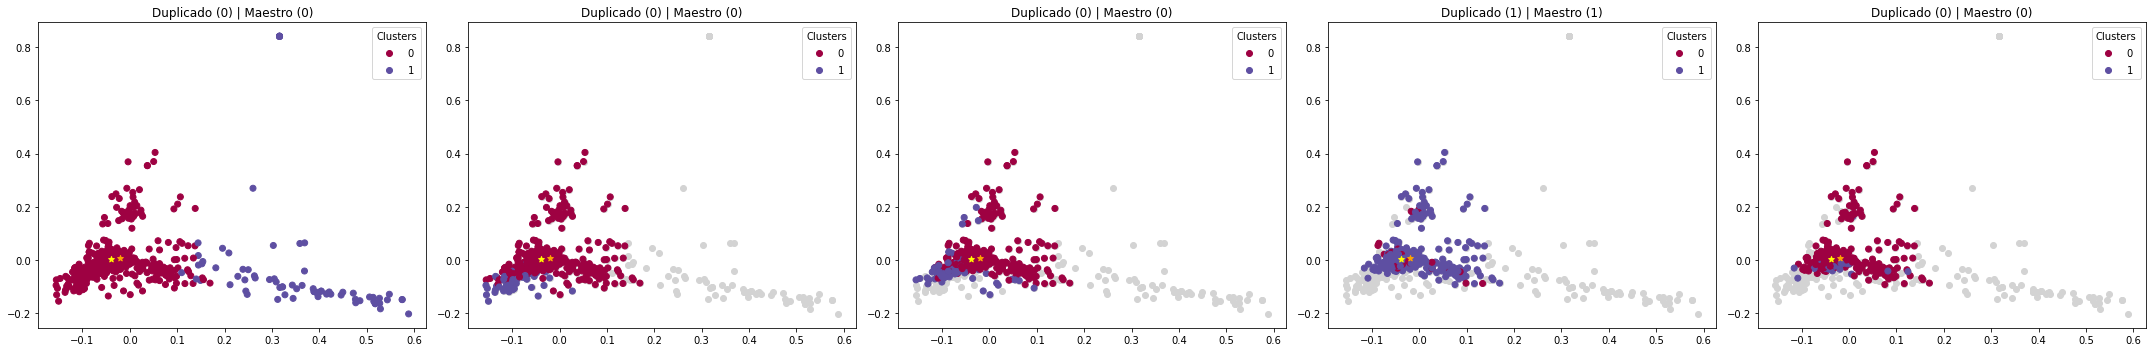

Número de reportes en el cluster final: 6 / 884 originales
--------------------------------------------------


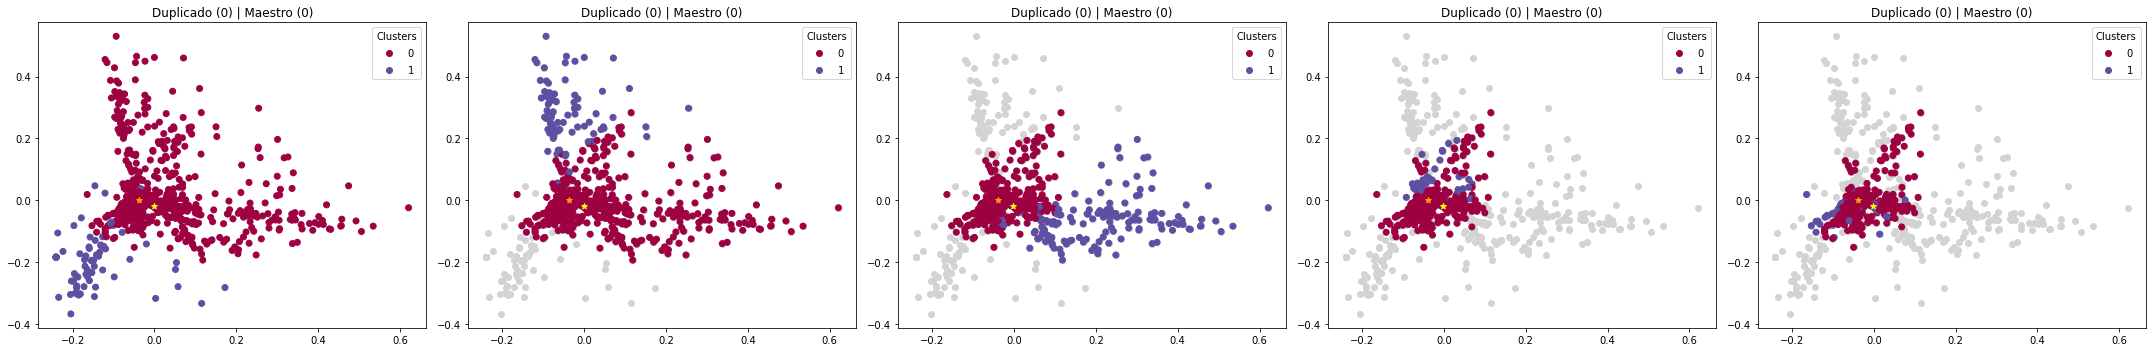

Número de reportes en el cluster final: 47 / 884 originales
--------------------------------------------------


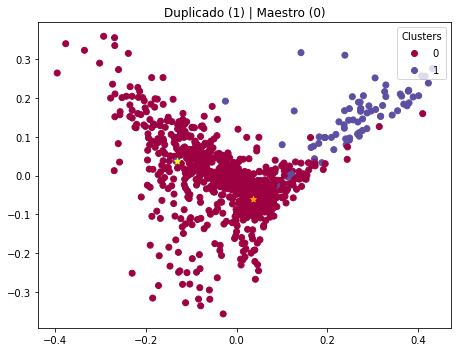

Número de reportes en el cluster final: 77 / 884 originales
--------------------------------------------------


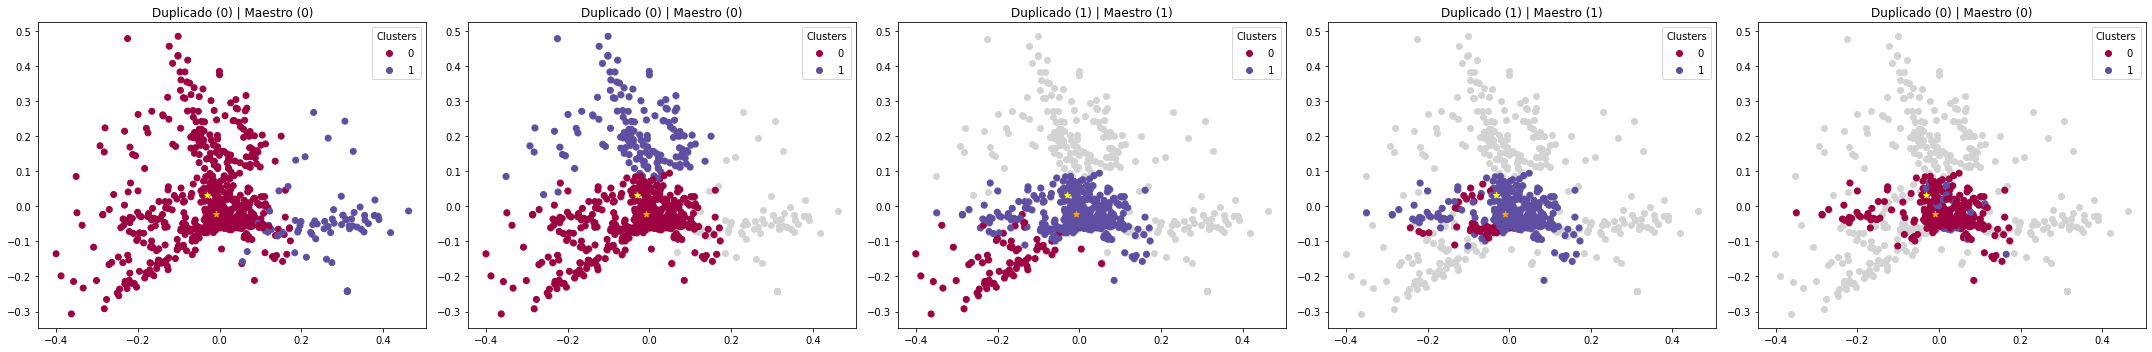

Número de reportes en el cluster final: 30 / 884 originales
--------------------------------------------------


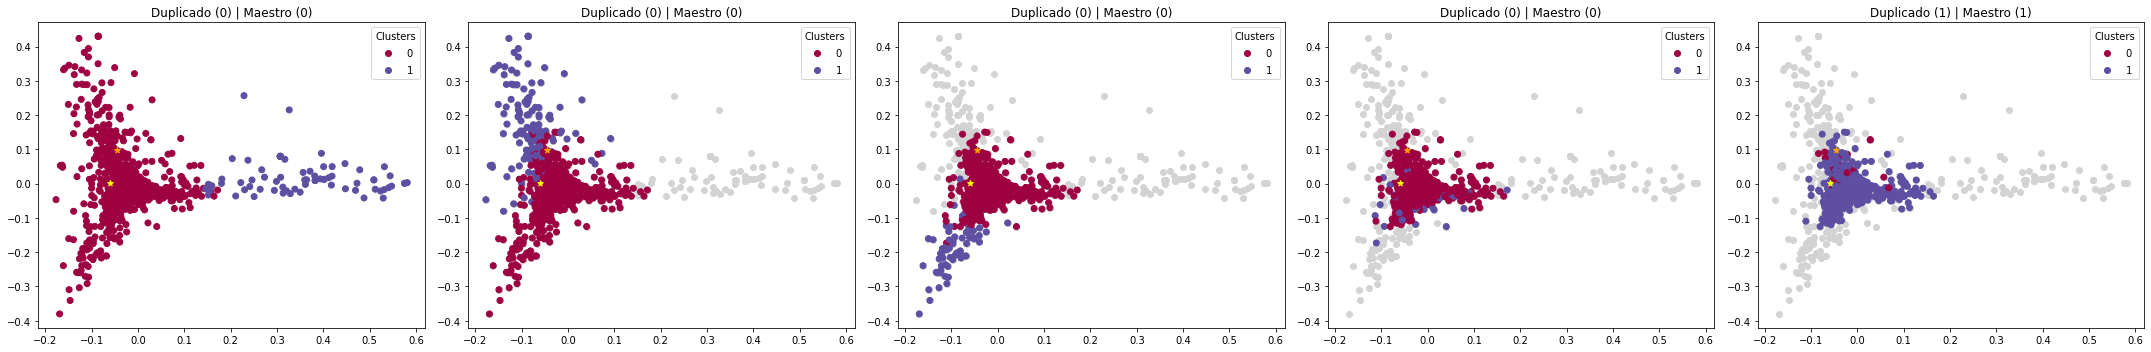

Número de reportes en el cluster final: 81 / 884 originales
--------------------------------------------------


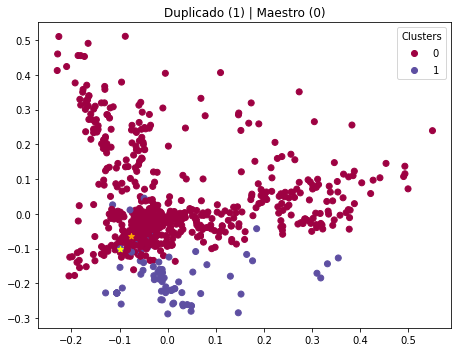

Número de reportes en el cluster final: 77 / 884 originales
--------------------------------------------------


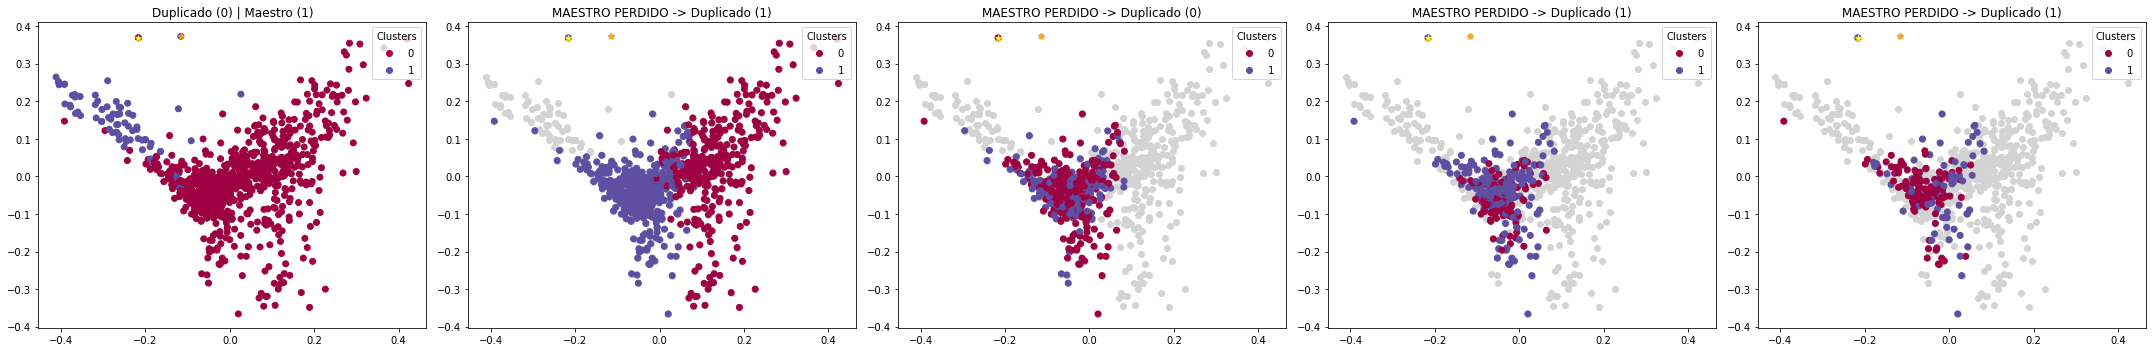

Número de reportes en el cluster final: 82 / 884 originales
--------------------------------------------------


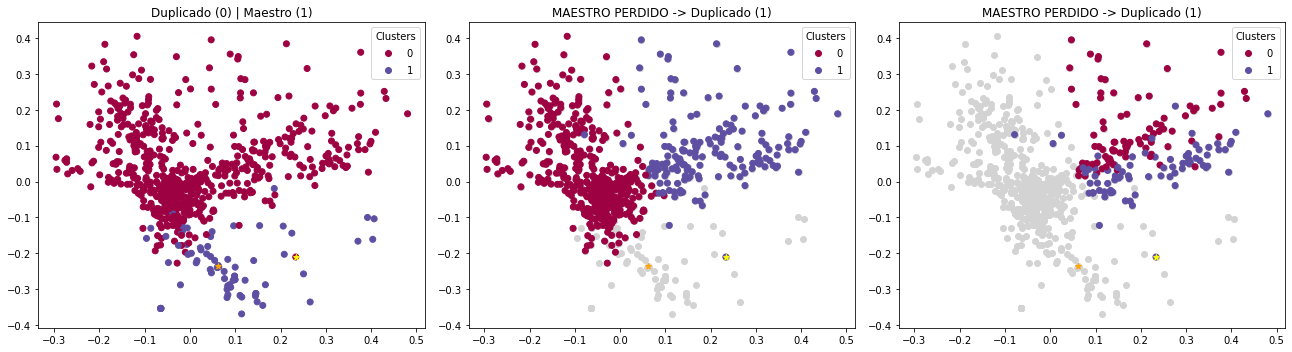

Número de reportes en el cluster final: 80 / 884 originales
--------------------------------------------------


In [64]:
cluster1L, cluster_data1L = plot_recursive_cluster(sample_1L, tfidf1L, kmeans1L_best_model, dfr, max_reports_cluster=100, tokenize_type='tokens1L')
print(f"Número de reportes en el cluster final: {len(cluster_data1L)} / {len(dfr)} originales")
print('-'*50)
cluster2L, cluster_data2L = plot_recursive_cluster(sample_2L, tfidf2L, kmeans2L_best_model, dfr, max_reports_cluster=100, tokenize_type='tokens2L')
print(f"Número de reportes en el cluster final: {len(cluster_data2L)} / {len(dfr)} originales")
print('-'*50)
cluster3L, cluster_data3L = plot_recursive_cluster(sample_3L, tfidf3L, kmeans3L_best_model, dfr, max_reports_cluster=100, tokenize_type='tokens3L')
print(f"Número de reportes en el cluster final: {len(cluster_data3L)} / {len(dfr)} originales")
print('-'*50)
cluster4L, cluster_data4L = plot_recursive_cluster(sample_4L, tfidf4L, kmeans4L_best_model, dfr, max_reports_cluster=100, tokenize_type='tokens4L')
print(f"Número de reportes en el cluster final: {len(cluster_data4L)} / {len(dfr)} originales")
print('-'*50)
cluster1S, cluster_data1S = plot_recursive_cluster(sample_1S, tfidf1S, kmeans1S_best_model, dfr, max_reports_cluster=100, tokenize_type='tokens1S')
print(f"Número de reportes en el cluster final: {len(cluster_data1S)} / {len(dfr)} originales")
print('-'*50)
cluster2S, cluster_data2S = plot_recursive_cluster(sample_2S, tfidf2S, kmeans2S_best_model, dfr, max_reports_cluster=100, tokenize_type='tokens2S')
print(f"Número de reportes en el cluster final: {len(cluster_data2S)} / {len(dfr)} originales")
print('-'*50)
cluster3S, cluster_data3S = plot_recursive_cluster(sample_3S, tfidf3S, kmeans3S_best_model, dfr, max_reports_cluster=100, tokenize_type='tokens3S')
print(f"Número de reportes en el cluster final: {len(cluster_data3S)} / {len(dfr)} originales")
print('-'*50)
cluster4S, cluster_data4S = plot_recursive_cluster(sample_4S, tfidf4S, kmeans4S_best_model, dfr, max_reports_cluster=100, tokenize_type='tokens4S')
print(f"Número de reportes en el cluster final: {len(cluster_data4S)} / {len(dfr)} originales")
print('-'*50)

#### Criterio de parada: Número de iteraciones

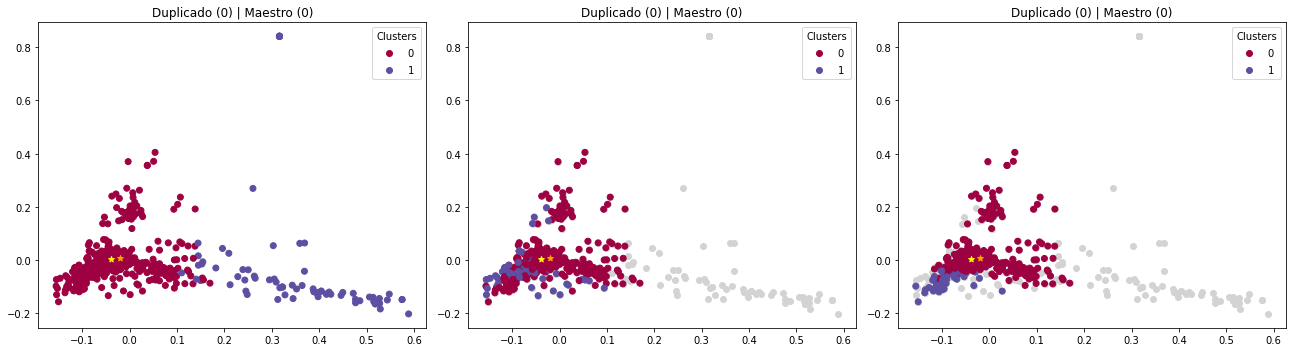

Número de reportes en el cluster final: 633 / 884 originales
--------------------------------------------------


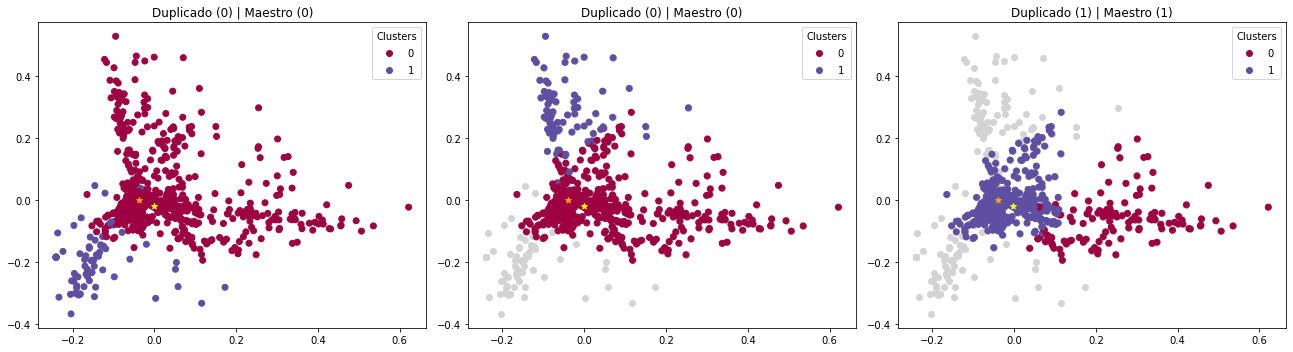

Número de reportes en el cluster final: 600 / 884 originales
--------------------------------------------------


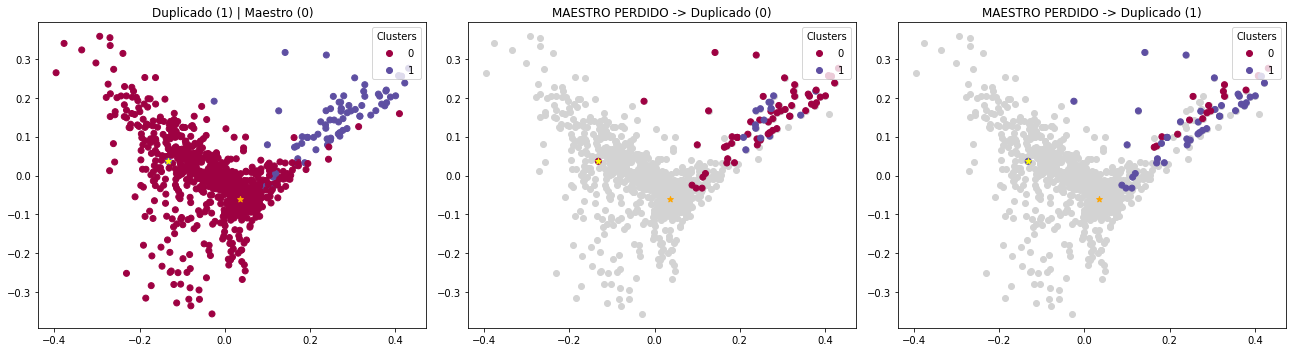

Número de reportes en el cluster final: 44 / 884 originales
--------------------------------------------------


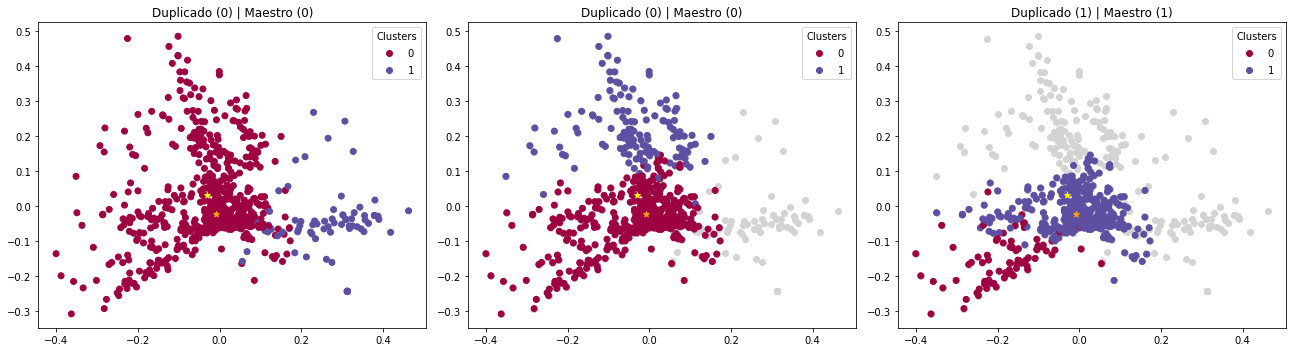

Número de reportes en el cluster final: 593 / 884 originales
--------------------------------------------------


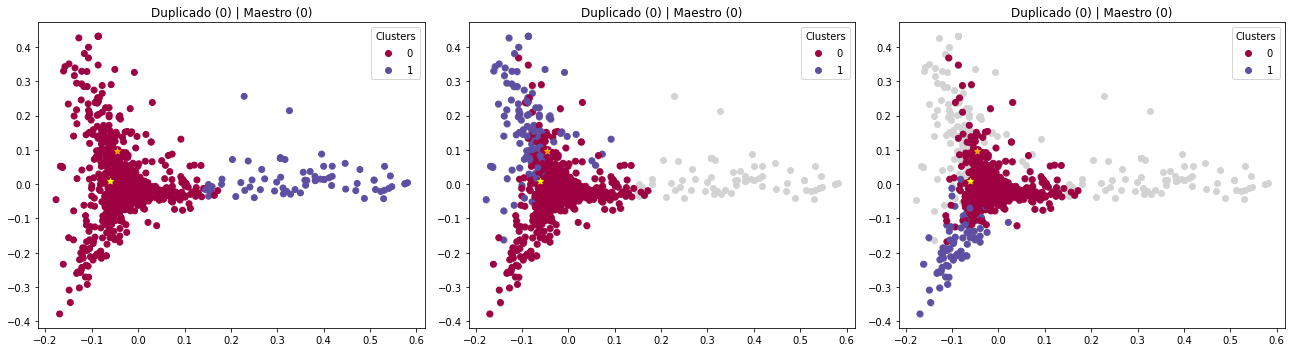

Número de reportes en el cluster final: 609 / 884 originales
--------------------------------------------------


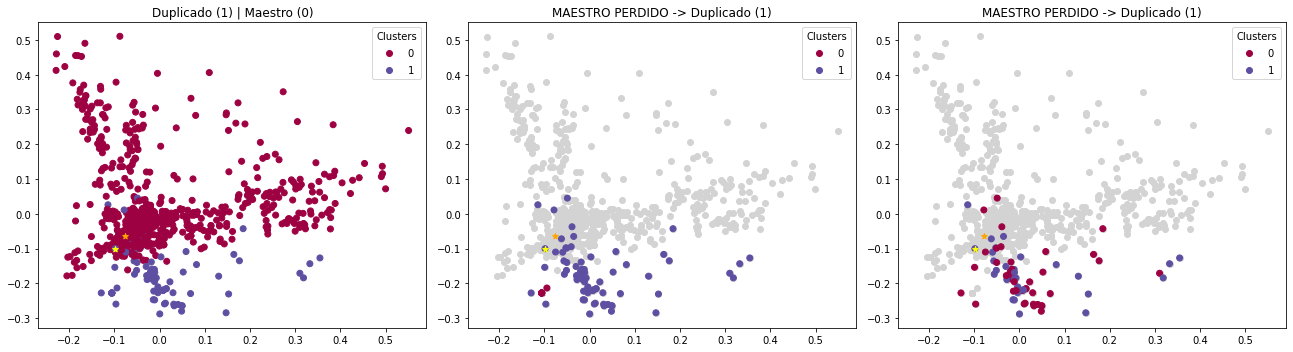

Número de reportes en el cluster final: 30 / 884 originales
--------------------------------------------------


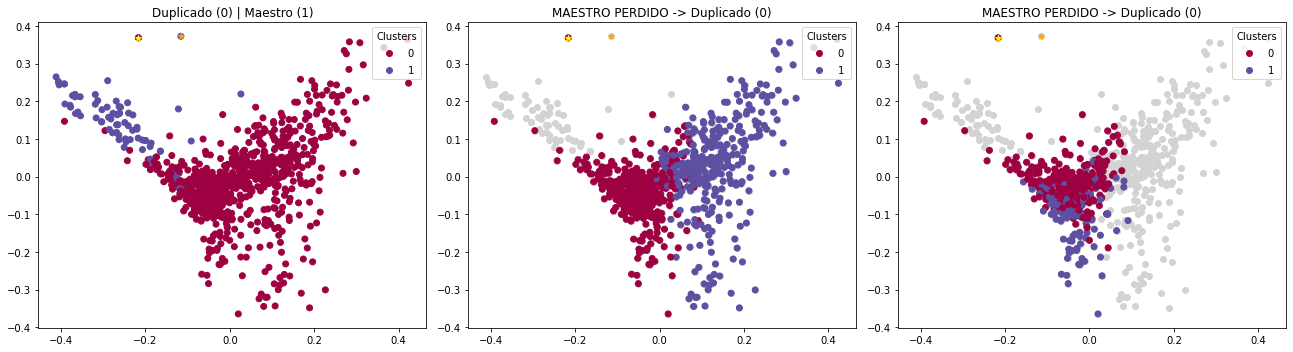

Número de reportes en el cluster final: 330 / 884 originales
--------------------------------------------------


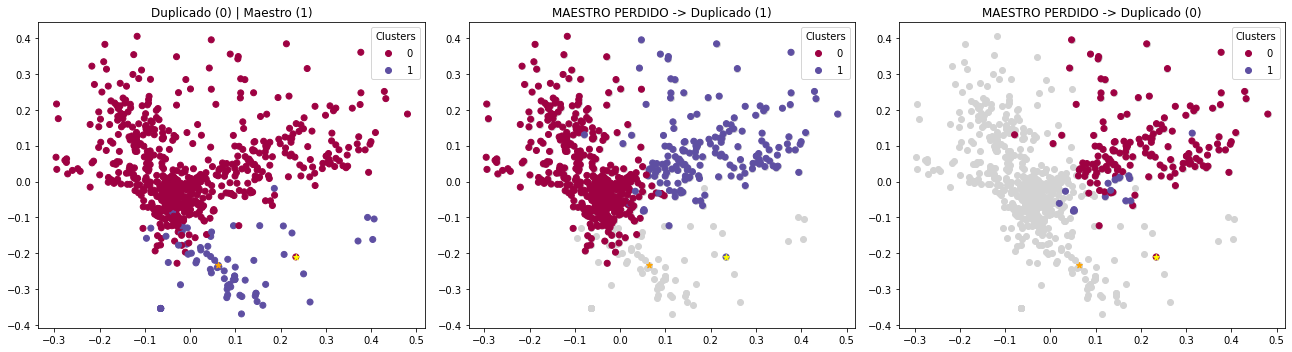

Número de reportes en el cluster final: 153 / 884 originales
--------------------------------------------------


In [67]:
cluster1L, cluster_data1L = plot_recursive_cluster(sample_1L, tfidf1L, kmeans1L_best_model, dfr, max_recursivity_lvl=3, tokenize_type='tokens1L')
print(f"Número de reportes en el cluster final: {len(cluster_data1L)} / {len(dfr)} originales")
print('-'*50)
cluster2L, cluster_data2L = plot_recursive_cluster(sample_2L, tfidf2L, kmeans2L_best_model, dfr, max_recursivity_lvl=3, tokenize_type='tokens2L')
print(f"Número de reportes en el cluster final: {len(cluster_data2L)} / {len(dfr)} originales")
print('-'*50)
cluster3L, cluster_data3L = plot_recursive_cluster(sample_3L, tfidf3L, kmeans3L_best_model, dfr, max_recursivity_lvl=3, tokenize_type='tokens3L')
print(f"Número de reportes en el cluster final: {len(cluster_data3L)} / {len(dfr)} originales")
print('-'*50)
cluster4L, cluster_data4L = plot_recursive_cluster(sample_4L, tfidf4L, kmeans4L_best_model, dfr, max_recursivity_lvl=3, tokenize_type='tokens4L')
print(f"Número de reportes en el cluster final: {len(cluster_data4L)} / {len(dfr)} originales")
print('-'*50)
cluster1S, cluster_data1S = plot_recursive_cluster(sample_1S, tfidf1S, kmeans1S_best_model, dfr, max_recursivity_lvl=3, tokenize_type='tokens1S')
print(f"Número de reportes en el cluster final: {len(cluster_data1S)} / {len(dfr)} originales")
print('-'*50)
cluster2S, cluster_data2S = plot_recursive_cluster(sample_2S, tfidf2S, kmeans2S_best_model, dfr, max_recursivity_lvl=3, tokenize_type='tokens2S')
print(f"Número de reportes en el cluster final: {len(cluster_data2S)} / {len(dfr)} originales")
print('-'*50)
cluster3S, cluster_data3S = plot_recursive_cluster(sample_3S, tfidf3S, kmeans3S_best_model, dfr, max_recursivity_lvl=3, tokenize_type='tokens3S')
print(f"Número de reportes en el cluster final: {len(cluster_data3S)} / {len(dfr)} originales")
print('-'*50)
cluster4S, cluster_data4S = plot_recursive_cluster(sample_4S, tfidf4S, kmeans4S_best_model, dfr, max_recursivity_lvl=3, tokenize_type='tokens4S')
print(f"Número de reportes en el cluster final: {len(cluster_data4S)} / {len(dfr)} originales")
print('-'*50)

# Persistencia de los modelos

In [70]:
import pickle
import os

if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('data/vectorizer'):
    os.makedirs('data/vectorizer')
if not os.path.exists('data/cluster'):
    os.makedirs('data/cluster')

pickle.dump(tfidf1L, open('data/vectorizer/tfidf1L.pkl', 'wb'))
pickle.dump(tfidf2L, open('data/vectorizer/tfidf2L.pkl', 'wb'))
pickle.dump(tfidf3L, open('data/vectorizer/tfidf3L.pkl', 'wb'))
pickle.dump(tfidf4L, open('data/vectorizer/tfidf4L.pkl', 'wb'))
pickle.dump(tfidf1S, open('data/vectorizer/tfidf1S.pkl', 'wb'))
pickle.dump(tfidf2S, open('data/vectorizer/tfidf2S.pkl', 'wb'))
pickle.dump(tfidf3S, open('data/vectorizer/tfidf3S.pkl', 'wb'))
pickle.dump(tfidf4S, open('data/vectorizer/tfidf4S.pkl', 'wb'))

pickle.dump(kmeans1L_best_model, open('data/cluster/kmeans1L.pkl', 'wb'))
pickle.dump(kmeans2L_best_model, open('data/cluster/kmeans2L.pkl', 'wb'))
pickle.dump(kmeans3L_best_model, open('data/cluster/kmeans3L.pkl', 'wb'))
pickle.dump(kmeans4L_best_model, open('data/cluster/kmeans4L.pkl', 'wb'))
pickle.dump(kmeans1S_best_model, open('data/cluster/kmeans1S.pkl', 'wb'))
pickle.dump(kmeans2S_best_model, open('data/cluster/kmeans2S.pkl', 'wb'))
pickle.dump(kmeans3S_best_model, open('data/cluster/kmeans3S.pkl', 'wb'))
pickle.dump(kmeans4S_best_model, open('data/cluster/kmeans4S.pkl', 'wb'))